## Tracking over days
Are fragmented cells across sessions the same set?
Apr 21, 2025

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import datajoint as dj
import spyglass as nd
import pandas as pd
import matplotlib.pyplot as plt

In [8]:
from spyglass.shijiegu.helpers import interval_union
from spyglass.shijiegu.Analysis_SGU import TrialChoice,RippleTimes,EpochPos,ExtendedRippleTimes,RippleTimesWithDecode
from spyglass.shijiegu.load import load_run_sessions
from spyglass.shijiegu.singleUnit import (do_mountainSort,electrode_unit,RippleTime2FiringRate,findWaveForms,RippleTime2Index,
                            )
from spyglass.shijiegu.fragmented import permute_frag_cont,find_spike_count_ratio,get_nwb_units
from spyglass.spikesorting.v0.spikesorting_curation import QualityMetrics
from spyglass.shijiegu.placefield import place_field
from spyglass.shijiegu.curation_manual import load_peak_amp, plot_spray_window, show_plot

#### day and sessions

In [9]:
nwb_copy_file_name = "lewis20240109_.nwb"
#nwb_copy_file_name = "eliot20221021_.nwb"

In [10]:
run_session_ids, run_session_names, pos_session_names = load_run_sessions(nwb_copy_file_name)

*nwb_file_name *epoch    epoch_name     position_inter
+------------+ +-------+ +------------+ +------------+
lewis20240109_ 1         01_Rev2Sleep1  pos 0 valid ti
lewis20240109_ 2         02_Rev2Session pos 1 valid ti
lewis20240109_ 3         03_Rev2Sleep2  pos 2 valid ti
lewis20240109_ 4         04_Rev2Session pos 3 valid ti
lewis20240109_ 5         05_Rev2Sleep3  pos 4 valid ti
lewis20240109_ 6         06_Rev2Session pos 5 valid ti
lewis20240109_ 7         07_Rev2Sleep4  pos 6 valid ti
lewis20240109_ 8         08_Rev2Session pos 7 valid ti
lewis20240109_ 9         09_Rev2Sleep5  pos 8 valid ti
 (Total: 9)



In [11]:
epoch_num1 = 0
epoch_num2 = 1

#### load ripple times

In [12]:
session_name1 = run_session_names[epoch_num1]
pos_name1 = pos_session_names[epoch_num1]

session_name2 = run_session_names[epoch_num2]
pos_name2 = pos_session_names[epoch_num2]

print(session_name1, session_name2)
print(pos_name1,pos_name2)

02_Rev2Session1 04_Rev2Session2
pos 1 valid times pos 3 valid times


In [13]:
ripple_times_all = []
for session_name in [session_name1, session_name2]:
    try:
        ripple_times = pd.DataFrame((RippleTimesWithDecode & 
                                 {'nwb_file_name': nwb_copy_file_name, 'interval_list_name': session_name}).fetch1('ripple_times'))
    except:
        ripple_times = pd.read_pickle((RippleTimesWithDecode & 
                                 {'nwb_file_name': nwb_copy_file_name, 'interval_list_name': session_name}).fetch1('ripple_times'))
    ripple_times_all.append(ripple_times)
ripple_times1, ripple_times2 = ripple_times_all

In [14]:
ripple_times1

event_number    start_time animal_location trial_number  \
0               1  1.704828e+09            home            1   
1               2  1.704828e+09            home            1   
2               3  1.704828e+09            home            2   
3               4  1.704828e+09            home            2   
4               5  1.704828e+09            home            2   
..            ...           ...             ...          ...   
176           177  1.704830e+09           well2           79   
177           178  1.704830e+09           well2           79   
178           179  1.704830e+09            home           80   
179           180  1.704830e+09            home           81   
180           181  1.704830e+09            home           81   

                                            cont_intvl  \
0    [[1704827597.9726489, 1704827598.3506489], [17...   
1           [[1704827600.6606483, 1704827601.6366482]]   
2           [[1704827604.0486476, 1704827604.6286476]]   
3            [[1704827609.058647, 1704827609.5626466]]   
4            [[1704827618.1426451, 1704827618.518645]]   
..                                                 ...   
176         [[1704829887.8602166, 1704829888.0642166]]   
177  [[1704829893.8662157, 1704829893.9742155], [17...   
178  [[1704829906.4822133, 1704829906.6222131], [17...   
179  [[1704829932.866208, 1704829932.9662082], [170...   
180  [[1704829935.6382077, 1704829935.9202075], [17...   

                                            frag_intvl  \
0                                                   []   
1                                                   []   
2                                                   []   
3                                                   []   
4                                                   []   
..                                                 ...   
176                                                 []   
177                                                 []   
178  [[1704829906.6242132, 1704829906.6742132], [17...   
179  [[1704829933.176208, 1704829933.308208], [1704...   
180                                                 []   

                         cont_intvl_replay      end_time  duration  \
0                            [[1], [], []]  1.704828e+09  0.888002   
1                                    [[0]]  1.704828e+09  0.978003   
2                                    [[0]]  1.704828e+09  0.582001   
3                                    [[3]]  1.704828e+09  0.507000   
4                                    [[3]]  1.704828e+09  0.378000   
..                                     ...           ...       ...   
176                                  [[2]]  1.704830e+09  0.263000   
177             [[2], [2], [], [], [1, 2]]  1.704830e+09  0.431000   
178  [[0], [], [], [], [], [], [], [], []]  1.704830e+09  1.083003   
179                      [[4], [], [], []]  1.704830e+09  0.610001   
180                             [[0], [1]]  1.704830e+09  0.472001   

     mean_zscore  median_zscore  max_zscore  min_zscore  max_speed  min_speed  \
0            NaN            NaN         NaN         NaN   0.056401   0.056400   
1       0.810976       0.611720    4.902610   -0.375640   0.056401   0.056400   
2       0.760839       0.589124    3.114255   -0.577900   0.056401   0.056400   
3       0.681824       0.402497    5.263690   -0.222113   0.056401   0.056400   
4       0.801214       0.696467    2.890186   -0.390811   0.056401   0.056400   
..           ...            ...         ...         ...        ...        ...   
176          NaN            NaN         NaN         NaN   4.355190   1.452820   
177     0.548005       0.321112    4.219078   -1.270932   0.865008   0.849712   
178     2.654417       1.657991   17.545821   -1.294060   0.980884   0.980081   
179          NaN            NaN         NaN         NaN   0.816311   0.809055   
180     1.530965       0.448096   13.742879   -1.087875   0.816313   0.816305   

     median_speed  mean_spee

#### determine fragmented cells

In [15]:
def find_fragmented_cells(nwb_copy_file_name, session_name, pos_name,
                          ripple_times, curation_id = 1, threshold = 5):

    curation_id = 1
    key = {"nwb_file_name": nwb_copy_file_name,
           "sorter":"mountainsort4",
           "sort_interval_name":session_name}
    
    sort_group_ids_with_good_cell = []
    sort_group_ids = np.unique((QualityMetrics & key).fetch("sort_group_id"))
    for sort_group_id in sort_group_ids:
        nwb_units = electrode_unit(nwb_copy_file_name,session_name,sort_group_id,curation_id = curation_id)
        
        #print("\n here")
        if nwb_units is None or len(nwb_units)==0:
            #print("\nhere", sort_group_id)
            continue
        print(len(nwb_units))
        sort_group_ids_with_good_cell.append(sort_group_id)
    print(sort_group_ids_with_good_cell)

    nwb_units_all = get_nwb_units(nwb_copy_file_name,session_name,sort_group_ids_with_good_cell,curation_id = curation_id)

    ratio, ratio_dict, firing_rate_F, firing_rate_C, unit_name = find_spike_count_ratio(nwb_units_all,ripple_times)

    candidates = []
    placefields = {}
    peak_frs = {}
    mobility_spike_counts = {}
    all_spike_counts = {}
    ratios = {}

    for unit in unit_name:
        (e, u) = unit
        placefield, peak_fr, xbins, ybins, mobility_spike_count, all_spike_count = place_field(
            nwb_copy_file_name, session_name, pos_name, e, u)

        if all_spike_count < 10:
            continue
        if ratio_dict[unit] >= threshold:
            candidates.append(unit)
            placefields[unit] = placefield
            peak_frs[unit] = peak_fr
            mobility_spike_counts[unit] = mobility_spike_count
            all_spike_counts[unit] = all_spike_count
            ratios[unit] = ratio_dict[unit]
            
    return candidates, placefields, peak_frs, mobility_spike_counts, all_spike_counts, ratio_dict, sort_group_ids_with_good_cell

In [ ]:
(candidates1, placefields1,
 peak_frs1, mobility_spike_counts1, all_spike_counts1, ratios1, all_sort_groups1) = find_fragmented_cells(
     nwb_copy_file_name, session_name1, pos_name1, ripple_times1, curation_id = 1)

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'ndx-franklab-novela' version 0.1.0 because version 0.2.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


8


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'ndx-franklab-novela' version 0.1.0 because version 0.2.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


3


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'ndx-franklab-novela' version 0.1.0 because version 0.2.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


4


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'ndx-franklab-novela' version 0.1.0 because version 0.2.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


7


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'ndx-franklab-novela' version 0.1.0 because version 0.2.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


5


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'ndx-franklab-novela' version 0.1.0 because version 0.2.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


7


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'ndx-franklab-novela' version 0.1.0 because version 0.2.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


2


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'ndx-franklab-novela' version 0.1.0 because version 0.2.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


10


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'ndx-franklab-novela' version 0.1.0 because version 0.2.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


8


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'ndx-franklab-novela' version 0.1.0 because version 0.2.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


9


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'ndx-franklab-novela' version 0.1.0 because version 0.2.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


3


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'ndx-franklab-novela' version 0.1.0 because version 0.2.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


3


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'ndx-franklab-novela' version 0.1.0 because version 0.2.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


5


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'ndx-franklab-novela' version 0.1.0 because version 0.2.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


8


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'ndx-franklab-novela' version 0.1.0 because version 0.2.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


9


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'ndx-franklab-novela' version 0.1.0 because version 0.2.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


7


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'ndx-franklab-novela' version 0.1.0 because version 0.2.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


6


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'ndx-franklab-novela' version 0.1.0 because version 0.2.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


In [ ]:
(candidates2, placefields2,
 peak_frs2, mobility_spike_counts2, all_spike_counts2, ratios2, all_sort_groups2) = find_fragmented_cells(
     nwb_copy_file_name, session_name2, pos_name2, ripple_times2, curation_id = 1)

In [ ]:
peak_frs2

#### find common sort groups

In [248]:
sort_group_ids1 = np.unique(np.array(candidates1)[:,0])
sort_group_ids2 = np.unique(np.array(candidates2)[:,0])

In [249]:
sort_group_ids = np.intersect1d(sort_group_ids1,sort_group_ids2)
sort_group_ids_all = np.intersect1d(all_sort_groups1,all_sort_groups2)

In [250]:
candidates1

[(14, 4), (27, 4)]

In [251]:
sort_group_ids

array([27])

#### make spray window, color code all cells with their cont/frag preference

In [252]:
import matplotlib.colors as colors
import matplotlib as mpl

cmap = plt.cm.seismic  # Example colormap
norm = colors.LogNorm(vmin=1/3, vmax=3, clip=True)

In [253]:
curation_id = 1

fig_sp1 = {}
fig_sp2 = {}
for sort_group_id in sort_group_ids_all:
    print("\n sort_group_id: ",sort_group_id)

    ### session 1
    peak_amp, timestamps = load_peak_amp(nwb_copy_file_name,session_name1,sort_group_id,curation_id)
    
    # colormap each cell with their continuous/fragmented preference
    color_map1 = {}
    all_units = peak_amp.keys()
    for u in all_units:
        color_map1[u] = cmap(norm(ratios1[(sort_group_id,u)]))
    
    fig_sp1[sort_group_id], _, color_map = plot_spray_window(peak_amp,color_map1)

    ### session 2
    peak_amp, timestamps = load_peak_amp(nwb_copy_file_name,session_name2,sort_group_id,curation_id)

    # colormap each cell with their continuous/fragmented preference
    color_map2 = {}
    all_units = peak_amp.keys()
    for u in all_units:
        color_map2[u] = cmap(norm(ratios2[(sort_group_id,u)]))
        
    fig_sp2[sort_group_id], _, _ = plot_spray_window(peak_amp,color_map2)


 sort_group_id:  0

 sort_group_id:  2

 sort_group_id:  5

 sort_group_id:  13

 sort_group_id:  14

 sort_group_id:  16

 sort_group_id:  17

 sort_group_id:  20

 sort_group_id:  23

 sort_group_id:  26

 sort_group_id:  27

 sort_group_id:  29

 sort_group_id:  30

 sort_group_id:  31


In [254]:
def show_2plots(list_of_f, list_of_title):

    list_of_f_with_title = []
    for f_ind in range(len(list_of_f)):
        f = list_of_f[f_ind]
        title = list_of_title[f_ind]
        list_of_f_with_title.append(show_plot(f, title))
    
    backend = mpl.get_backend()
    mpl.use('agg')
    
    dpi = 200

    list_of_farrays = []
    for f in list_of_f_with_title:
        c = f.canvas
        c.draw()
        a = np.array(c.buffer_rgba())
        list_of_farrays.append(a)
        
    a = np.vstack(list_of_farrays)
    
    mpl.use(backend)
    fig,ax = plt.subplots(figsize=(24, 4 * len(list_of_f)), dpi=dpi)
    fig.subplots_adjust(0, 0, 1, 1)
    ax.set_axis_off()
    ax.matshow(a)

In [255]:
figures = []
titles = []

for sort_group_id in sort_group_ids:
    title1 = nwb_copy_file_name + " " + session_name1 + " spray window: sort group " + str(sort_group_id)
    figures.append(fig_sp1[sort_group_id])
    titles.append(title1)
    
    title2 = nwb_copy_file_name + " " + session_name2 + " spray window: sort group " + str(sort_group_id)
    figures.append(fig_sp2[sort_group_id])
    titles.append(title2)

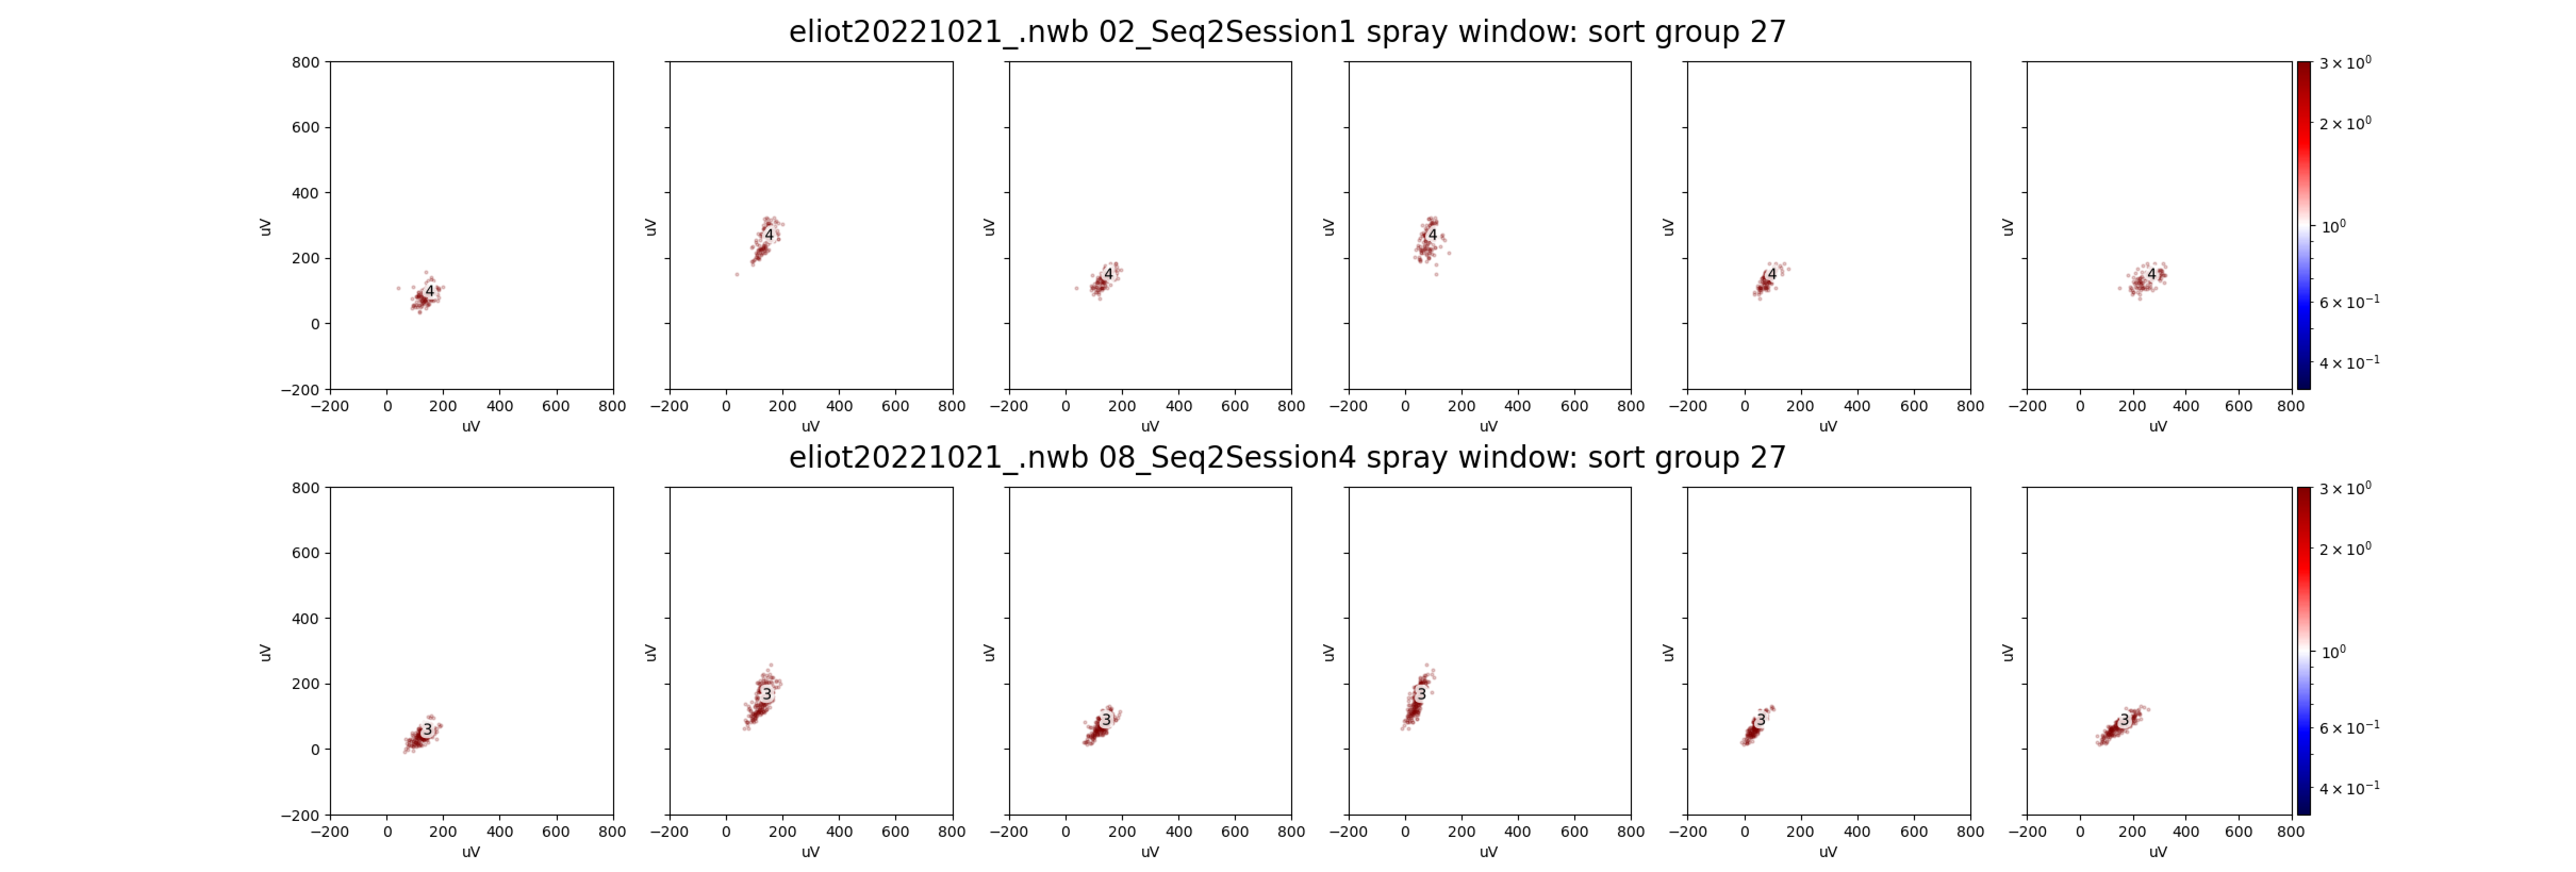

In [256]:
show_2plots(figures, titles)

#### plot all common tetrodes, instead of finding common tetrodes that have fragmented cells on both sessions

In [257]:
figures = []
titles = []

for sort_group_id in sort_group_ids_all:
    title1 = nwb_copy_file_name + " " + session_name1 + " spray window: sort group " + str(sort_group_id)
    figures.append(fig_sp1[sort_group_id])
    titles.append(title1)
    
    title2 = nwb_copy_file_name + " " + session_name2 + " spray window: sort group " + str(sort_group_id)
    figures.append(fig_sp2[sort_group_id])
    titles.append(title2)

In [258]:
show_2plots(figures, titles)

#### place field

spike num: 395
spike num: 388


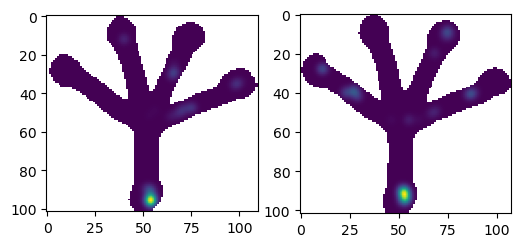

In [282]:
pairs = [(7,12),(7,16)]
f,ax = plt.subplots(1,2,figsize = (6,3))

placefield1, peak_fr, xbins, ybins, mobility_spike_count, all_spike_count = place_field(
            nwb_copy_file_name, session_name1, pos_name1, pairs[0][0], pairs[0][1])
placefield2, peak_fr, xbins, ybins, mobility_spike_count, all_spike_count = place_field(
            nwb_copy_file_name, session_name2, pos_name2, pairs[1][0], pairs[1][1])

ax[0].imshow(placefield1)
ax[1].imshow(placefield2)

spike num: 1595
spike num: 684


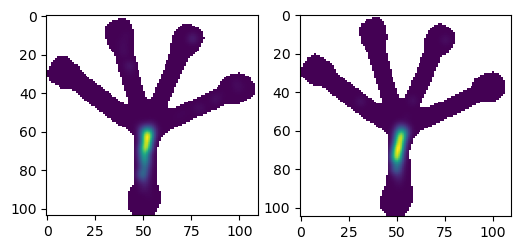

In [264]:
pairs = [(17,7),(17,14)]
f,ax = plt.subplots(1,2,figsize = (6,3))

placefield1, peak_fr, xbins, ybins, mobility_spike_count, all_spike_count = place_field(
            nwb_copy_file_name, session_name1, pos_name1, pairs[0][0], pairs[0][1])
placefield2, peak_fr, xbins, ybins, mobility_spike_count, all_spike_count = place_field(
            nwb_copy_file_name, session_name2, pos_name2, pairs[1][0], pairs[1][1])

ax[0].imshow(placefield1)
ax[1].imshow(placefield2)

spike num: 338
spike num: 466


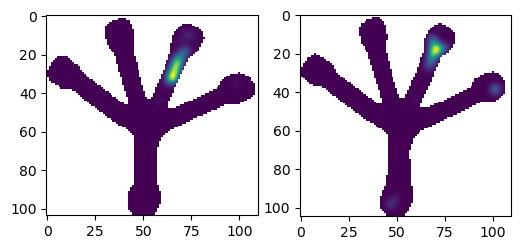

In [261]:
pairs = [(16,9),(16,10)]
f,ax = plt.subplots(1,2,figsize = (6,3))

placefield1, peak_fr, xbins, ybins, mobility_spike_count, all_spike_count = place_field(
            nwb_copy_file_name, session_name1, pos_name1, pairs[0][0], pairs[0][1])
placefield2, peak_fr, xbins, ybins, mobility_spike_count, all_spike_count = place_field(
            nwb_copy_file_name, session_name2, pos_name2, pairs[1][0], pairs[1][1])

ax[0].imshow(placefield1)
ax[1].imshow(placefield2)

In [226]:
candidates1

[(9, 4),
 (13, 12),
 (13, 13),
 (15, 19),
 (20, 18),
 (21, 7),
 (23, 13),
 (25, 11),
 (29, 4),
 (29, 8),
 (39, 4),
 (40, 3),
 (40, 11),
 (44, 4),
 (61, 7)]

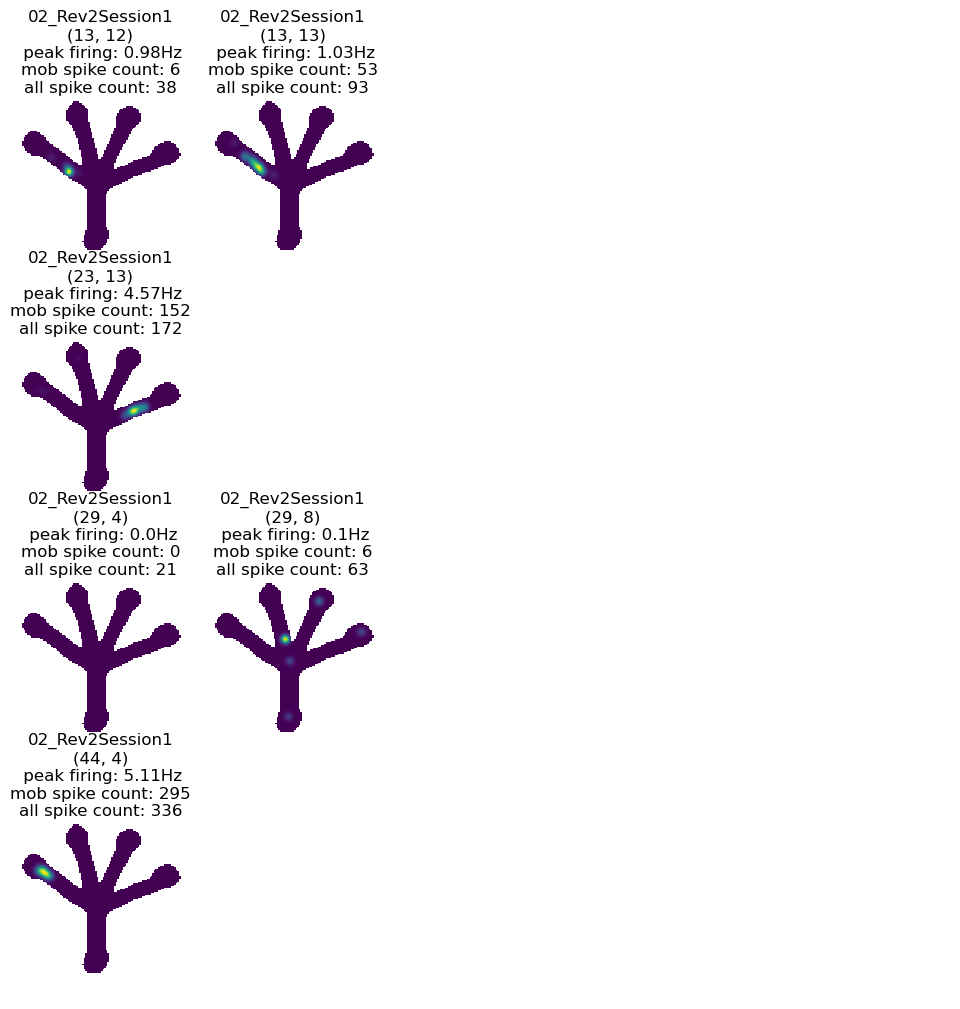

In [236]:
f,ax = plt.subplots(len(sort_group_ids),5,figsize = (12,3 * len(sort_group_ids)))

row_ind = 0
for sort_group_id in sort_group_ids:
    ind = 0
    for c1 in candidates1:
        if c1[0] == sort_group_id:
            ax[row_ind,ind].imshow(placefields1[c1])

            ax[row_ind,ind].set_title(session_name1 +"\n"+ str(c1) + "\n peak firing: " + str(np.round(peak_frs1[c1],2)) + "Hz\nmob spike count: " + str(mobility_spike_counts1[c1]) + "\nall spike count: " + str(all_spike_counts1[c1]))
            ind += 1

    for _ in range(5):
        ax[row_ind,_].set_axis_off()
    row_ind += 1
    
        

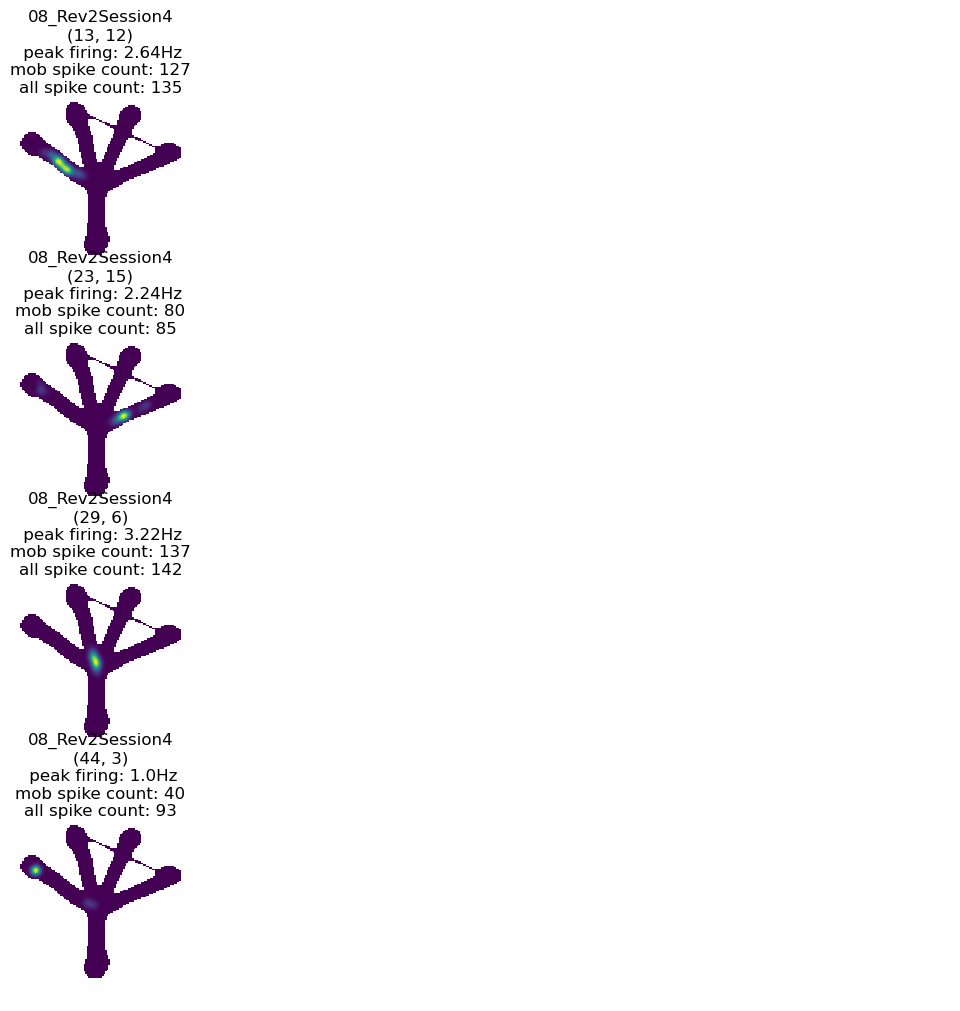

In [237]:
f,ax = plt.subplots(len(sort_group_ids),5,figsize = (12,3 * len(sort_group_ids)))

row_ind = 0
for sort_group_id in sort_group_ids:
    ind = 0
    for c1 in candidates2:
        if c1[0] == sort_group_id:
            ax[row_ind,ind].imshow(placefields2[c1])

            ax[row_ind,ind].set_title(session_name2 +"\n"+ str(c1) + "\n peak firing: " + str(np.round(peak_frs2[c1],2)) + "Hz\nmob spike count: " + str(mobility_spike_counts2[c1]) + "\nall spike count: " + str(all_spike_counts2[c1]))
            ind += 1

    for _ in range(5):
        ax[row_ind,_].set_axis_off()
    row_ind += 1